In [8]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


# Step-by-Step Detailed Overview of the Data Processing and Sentiment Analysis Workflow

This workflow consists of two main parts:
1. **Filtering and Saving Summaries with Minimum Character Requirement**
2. **Analyzing Sentiment and Merging with Movie Metadata**

## Part 1: Filtering and Saving Summaries with Minimum Character Requirement

### Step 1.1: Import Necessary Libraries
We start by importing the `pandas` library, which will be used for data manipulation, and Python's built-in file handling functionality.

### Step 1.2: Define File Paths
We specify the path to the `plot_summaries.txt` file (containing movie summaries) and define an output path where the filtered summaries will be saved in TSV format.

### Step 1.3: Filter Summaries with Sufficient Length
We open the `plot_summaries.txt` file and iterate through each line, which contains a movie's ID and its summary, separated by a tab. For each line:
- We try to split the line into `movie_id` and `summary`.
- We check if the summary has at least 1000 characters.
- If it does, we extract the last 400 characters and store them in a list `data`, paired with the `movie_id`.

If a line doesn't conform to the expected format, it's ignored, and a message is printed.

### Step 1.4: Save Filtered Data to a TSV File
Once all lines are processed, the filtered summaries are saved to a new TSV file (`filtered_plot_summaries_last_400_characters.tsv`) using `pandas.DataFrame`.

## Part 2: Analyzing Sentiment and Merging with Movie Metadata

### Step 2.1: Load Movie Metadata and Summary Files
We import the `textblob` library for sentiment analysis, and `pandas` for data processing.

### Step 2.2: Load Movie Metadata and Filtered Summaries
We load:
- The `movie.metadata.tsv` file, which contains information such as `Movie_ID`, `Title`, `Release_Date`, etc., while setting the `Movie_ID` column as a string for consistency.
- The `filtered_plot_summaries_last_400_characters.tsv` file created in Part 1, containing filtered summaries.

### Step 2.3: Define the Sentiment Analysis Function
Using `TextBlob`, we define a function to analyze sentiment polarity of each summary:
- A high positive polarity (> 0.5) corresponds to a "Very Happy Ending" (Score = 5).
- A moderate positive polarity (between 0.13 and 0.5) is a "Happy Ending" (Score = 4).
- A neutral polarity (between -0.13 and 0.13) is classified as "Neutral" (Score = 3).
- A moderate negative polarity (between -0.5 and -0.13) is labeled as a "Sad Ending" (Score = 2).
- A highly negative polarity (< -0.5) represents a "Very Sad Ending" (Score = 1).

### Step 2.4: Merge Metadata and Summary Data on Movie ID
We use an inner join to merge `movie_data` and `summaries_data` on the `Movie_ID` column, resulting in a combined dataset of only the movies that have both metadata and summaries.

### Step 2.5: Apply Sentiment Analysis
The `analyze_sentiment` function is applied to the `Summary` column of the merged dataset to generate a `Score` column, representing the sentiment score for each movie.

### Step 2.6: Save the Final Dataset
Finally, the combined dataset with sentiment scores is saved to a TSV file, `movies_dataset_w_scores.tsv`, for further analysis.


In [60]:
import pandas as pd

file_path = 'plot_summaries.txt'
output_file_path = 'filtered_plot_summaries_last_400_characters.tsv'
data = []

with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        try:
            movie_id, summary = line.split('\t', 1)  
            summary = summary.strip()  
            
            if len(summary) >= 1000:
                last_400_characters = summary[-400:].strip()
                data.append({'Movie_ID': movie_id, 'Summary': last_400_characters})
                
        except ValueError:
            print(f"Ligne ignorée (mauvais format) : {line}")

df = pd.DataFrame(data)

df.to_csv(output_file_path, sep='\t', index=False)

print(f"Fichier TSV créé avec succès : {output_file_path}")


Fichier TSV créé avec succès : filtered_plot_summaries_last_400_characters.tsv


In [61]:
import pandas as pd
from textblob import TextBlob

metadata_path = 'movie.metadata.tsv'
movie_data = pd.read_csv(metadata_path, sep='\t', header=None, dtype={0: str})  # Charger l'ID comme chaîne
movie_data.columns = ['Movie_ID', 'Other_Column', 'Title', 'Release_Date', 'Revenue', 'Runtime', 'Languages', 'Country', 'Genres']

summaries_path = 'filtered_plot_summaries_last_300_characters.tsv'
summaries_data = pd.read_csv(summaries_path, sep='\t', dtype={'Movie_ID': str})

print("Premières lignes de movie_data :")
print(movie_data.head())

print("Premières lignes de summaries_data :")
print(summaries_data.head())

def analyze_sentiment(summary):
    analysis = TextBlob(summary)
    polarity = analysis.sentiment.polarity
    if polarity > 0.5:
        return 5  # Very happy ending
    elif 0.13 < polarity <= 0.5:
        return 4  # Happy ending
    elif -0.13 <= polarity <= 0.13:
        return 3  # Neutral ending
    elif -0.5 < polarity < -0.13:
        return 2  # Sad ending
    else:
        return 1  # Very sad ending

merged_data = pd.merge(movie_data, summaries_data, on='Movie_ID', how='inner')

print(f"Nombre de films avec correspondance : {len(merged_data)}")

merged_data['Score'] = merged_data['Summary'].apply(analyze_sentiment)

output_file_path = 'movies_dataset_w_scores.tsv'
merged_data.to_csv(output_file_path, sep='\t', index=False)

print(f"Dataset avec scores sauvegardé dans {output_file_path}")


Premières lignes de movie_data :
   Movie_ID Other_Column                                              Title  \
0    975900    /m/03vyhn                                     Ghosts of Mars   
1   3196793    /m/08yl5d  Getting Away with Murder: The JonBenét Ramsey ...   
2  28463795   /m/0crgdbh                                        Brun bitter   
3   9363483   /m/0285_cd                                   White Of The Eye   
4    261236    /m/01mrr1                                  A Woman in Flames   

  Release_Date     Revenue  Runtime                           Languages  \
0   2001-08-24  14010832.0     98.0  {"/m/02h40lc": "English Language"}   
1   2000-02-16         NaN     95.0  {"/m/02h40lc": "English Language"}   
2         1988         NaN     83.0  {"/m/05f_3": "Norwegian Language"}   
3         1987         NaN    110.0  {"/m/02h40lc": "English Language"}   
4         1983         NaN    106.0   {"/m/04306rv": "German Language"}   

                                     Coun

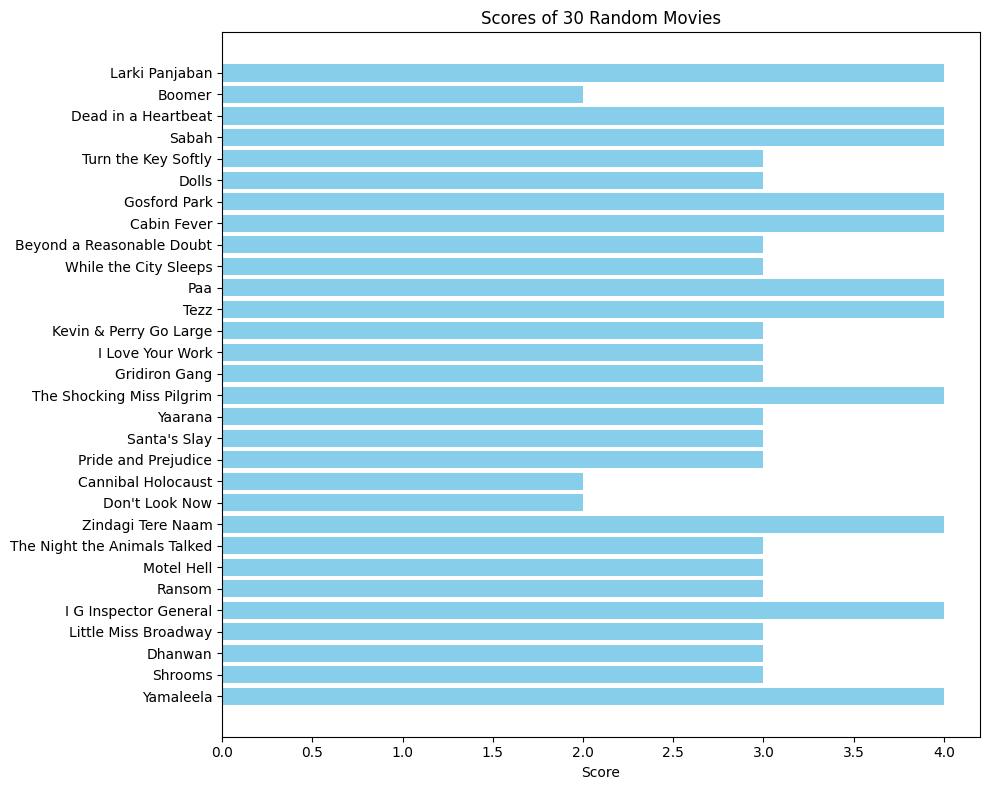

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'movies_dataset_w_scores.tsv'
movie_data = pd.read_csv(file_path, sep='\t')

sample_movies = movie_data.sample(n=30, random_state=42)

plt.figure(figsize=(10, 8))
plt.barh(sample_movies['Title'], sample_movies['Score'], color='skyblue')
plt.xlabel('Score')
plt.title('Scores of 30 Random Movies')
plt.gca().invert_yaxis()  #
plt.tight_layout()
plt.show()


### Code Explanation

This code calculates and adds the average age of characters per movie to the main movie dataset. Here is an outline of each step:

1. **Data Loading**: Load the main movie dataset (`movies_dataset_w_scores.tsv`) and the character dataset (`character.metadata.tsv`). The character dataset includes details like character name, birth date, and age.

2. **Data Preparation**: Convert the `Movie_ID` column in the character dataset and `Other_Column` in the movie dataset to string format to ensure compatibility for merging.

3. **Filter and Calculate Average Age**: Remove rows with missing ages in the character dataset, then calculate the average age of characters for each movie (`Movie_ID`). Round the result to two decimal places for readability.

4. **Merging the Average Age**: Merge the average age data into the main movie dataset by matching `Other_Column` (movie dataset) to `Movie_ID` (character dataset). Drop the extra `Movie_ID` column from the merged dataset to avoid redundancy.

5. **Saving the Updated Dataset**: Export the updated movie dataset, now containing the average character age per movie, to a new TSV file (`movies_dataset_w_scores_with_age.tsv`).

This code provides a quick way to integrate character age insights into the main movie dataset, enhancing analysis potential.


In [62]:
import pandas as pd

# Load the datasets of movies and characters
movies_df = pd.read_csv('movies_dataset_w_scores.tsv', sep='\t')
characters_df = pd.read_csv('character.metadata.tsv', sep='\t', header=None, 
                            names=["Movie_ID", "Freebase_ID", "Release_Date", "Character_Name", 
                                   "Birth_Date", "Gender", "Height", "Actor_Name", "Age", 
                                   "Actor_Freebase_ID", "Character_Freebase_ID", "Actor_Character_Freebase_ID"])

# Ensure Movie_IDs are string types in both DataFrames
movies_df['Other_Column'] = movies_df['Other_Column'].astype(str)
characters_df['Movie_ID'] = characters_df['Movie_ID'].astype(str)

# Remove rows without 'Age' for accurate calculations
characters_df = characters_df.dropna(subset=['Age'])

# Calculate the average age for each Movie_ID
movie_age_stats = characters_df.groupby('Movie_ID').agg(
    Average_Age=('Age', 'mean')
).reset_index()

# Round the average age for better readability
movie_age_stats['Average_Age'] = movie_age_stats['Average_Age'].round(2)

# Display a sample of the calculated age statistics for verification
print("Sample age statistics for movies:")
print(movie_age_stats.head())

# Merge the calculated age statistics with the movies DataFrame, using 'Other_Column' to match 'Movie_ID'
movies_df = pd.merge(movies_df, movie_age_stats, left_on='Other_Column', right_on='Movie_ID', how='left')

# Check if 'Movie_ID' is present, then drop it to avoid KeyError
if 'Movie_ID' in movies_df.columns:
    movies_df = movies_df.drop(columns=['Movie_ID'])

# Save the updated dataset with the new 'Average_Age' column back to the original file
movies_df.to_csv('movies_dataset_w_scores.tsv', sep='\t', index=False)

print("Dataset updated with average age and saved as 'movies_dataset_w_scores.tsv'")


Sample age statistics for movies:
    Movie_ID  Average_Age
0  /m/011_mj        20.00
1  /m/011_p6        21.00
2  /m/011_zy        25.00
3  /m/011wtv        36.89
4  /m/011x_4        37.60
Dataset updated with average age and saved as 'movies_dataset_w_scores.tsv'


### Code Explanation and Interpretation

This code segment calculates the correlation between two variables in the movie dataset (`movies_dataset_w_scores_with_stats.tsv`) and the movie score. Here’s a breakdown:

1. **Data Loading**: Load the dataset containing movie information, including average age of the cast, runtime, and score.

2. **Correlation Calculation**:
   - **Average Age vs. Score**: Compute the correlation between the average age of the movie's cast and the movie score. The result here is `0.00185`, indicating a negligible correlation. This suggests that the age of the cast members does not significantly impact or correlate with the movie's score.
   - **Runtime vs. Score**: Calculate the correlation between the movie runtime and the score, resulting in `-0.00198`. This low, near-zero negative correlation also suggests no meaningful relationship between a movie’s runtime and its score.

3. **Interpretation**:
   - Both results show that neither the average age of the cast nor the runtime of the movie has a strong or notable correlation with the movie's score. This implies that these factors likely don’t influence movie ratings, or at least that no consistent relationship exists in this dataset.
   
In summary, based on these correlations, there appears to be no significant impact of either cast age or runtime on movie scores.


In [63]:
import pandas as pd

# Load the dataset
movies_df = pd.read_csv('movies_dataset_w_scores.tsv', sep='\t')

# Calculate correlation between Average Age and Score
age_score_corr = movies_df['Average_Age'].corr(movies_df['Score'])
print(f"Correlation between Average Age of Cast and Movie Score: {age_score_corr}")

# Calculate correlation between Runtime and Score
runtime_score_corr = movies_df['Runtime'].corr(movies_df['Score'])
print(f"Correlation between Runtime of Movie and Movie Score: {runtime_score_corr}")


Correlation between Average Age of Cast and Movie Score: -0.0029186707758598373
Correlation between Runtime of Movie and Movie Score: -0.0019857974182977186


### Code Explanation and Interpretation

This code segment calculates the correlation between movie revenue and movie score, assessing whether there’s a meaningful relationship between a film’s financial success and its rating.

1. **Data Loading**: Load the dataset `movies_dataset_w_scores_with_stats.tsv` into a DataFrame.

2. **Data Preparation**:
   - **Revenue as Numeric**: Convert the `Revenue` column to a numeric type, setting non-numeric entries as NaN. This step ensures that only valid numeric values are used in the correlation calculation, which is crucial for obtaining accurate results.

3. **Correlation Calculation**:
   - Compute the correlation between `Revenue` and `Score`, yielding a result of `0.05`. This very low positive correlation indicates that revenue has almost no linear relationship with movie scores.

4. **Interpretation**:
   - A correlation of `0.05` suggests that higher or lower revenue is not consistently associated with higher or lower movie scores. Thus, in this dataset, revenue appears to be largely independent of movie ratings, and we can conclude that box office success doesn’t necessarily imply a high movie score.

In summary, based on this low correlation, there is no significant relationship between revenue and movie ratings.


In [64]:
import pandas as pd

# Load the dataset
movies_df = pd.read_csv('movies_dataset_w_scores.tsv', sep='\t')

# Ensure Revenue is numeric, replacing non-numeric values with NaN
movies_df['Revenue'] = pd.to_numeric(movies_df['Revenue'], errors='coerce')

# Calculate correlation between Revenue and Score
revenue_score_corr = movies_df[['Revenue', 'Score']].corr().iloc[0, 1]
print(f"Correlation between Revenue and Score: {revenue_score_corr:.2f}")


Correlation between Revenue and Score: 0.05


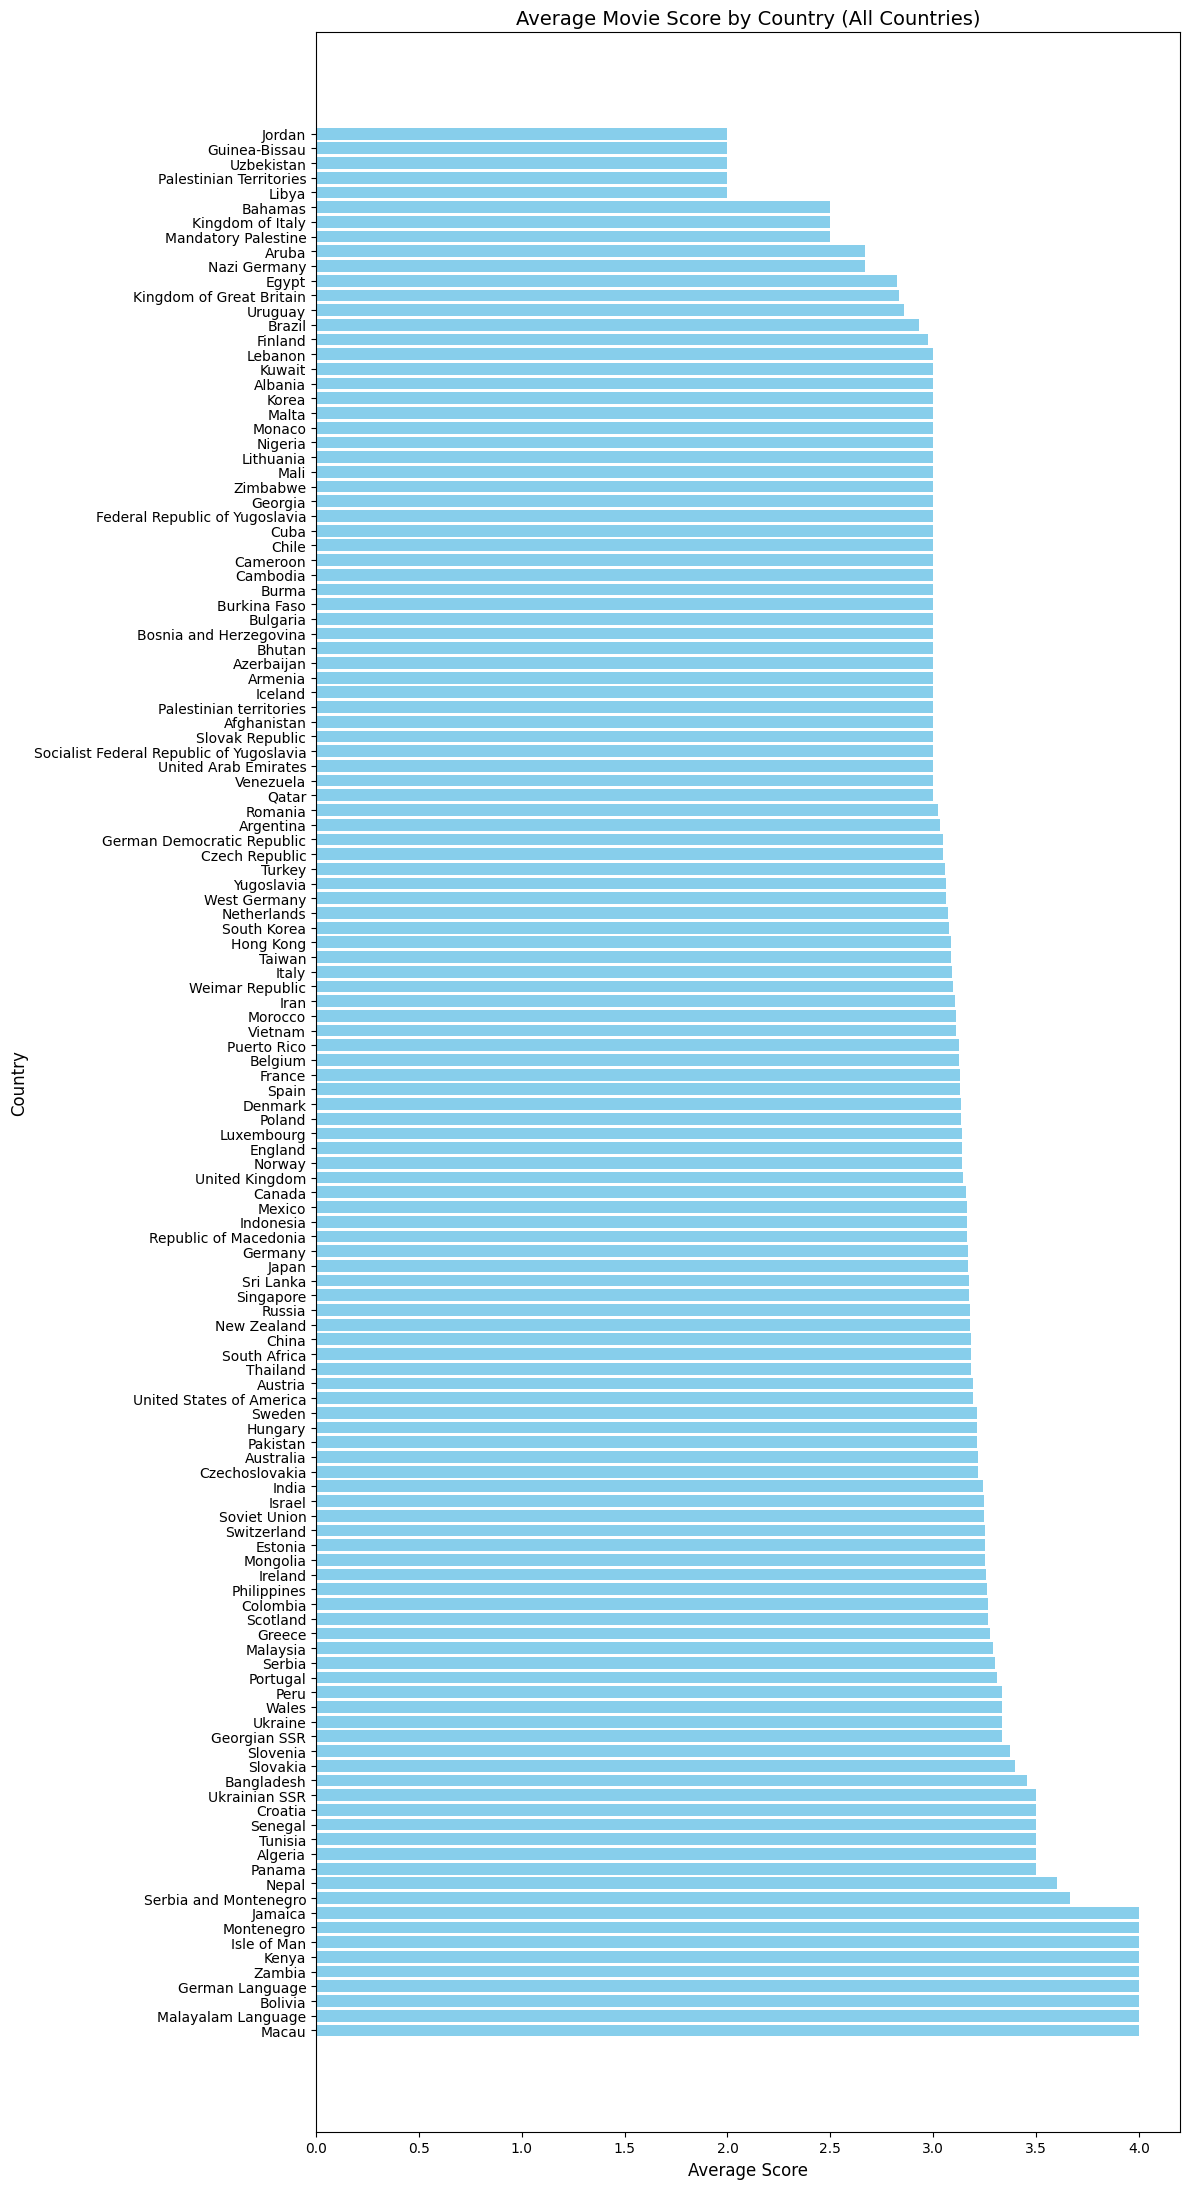

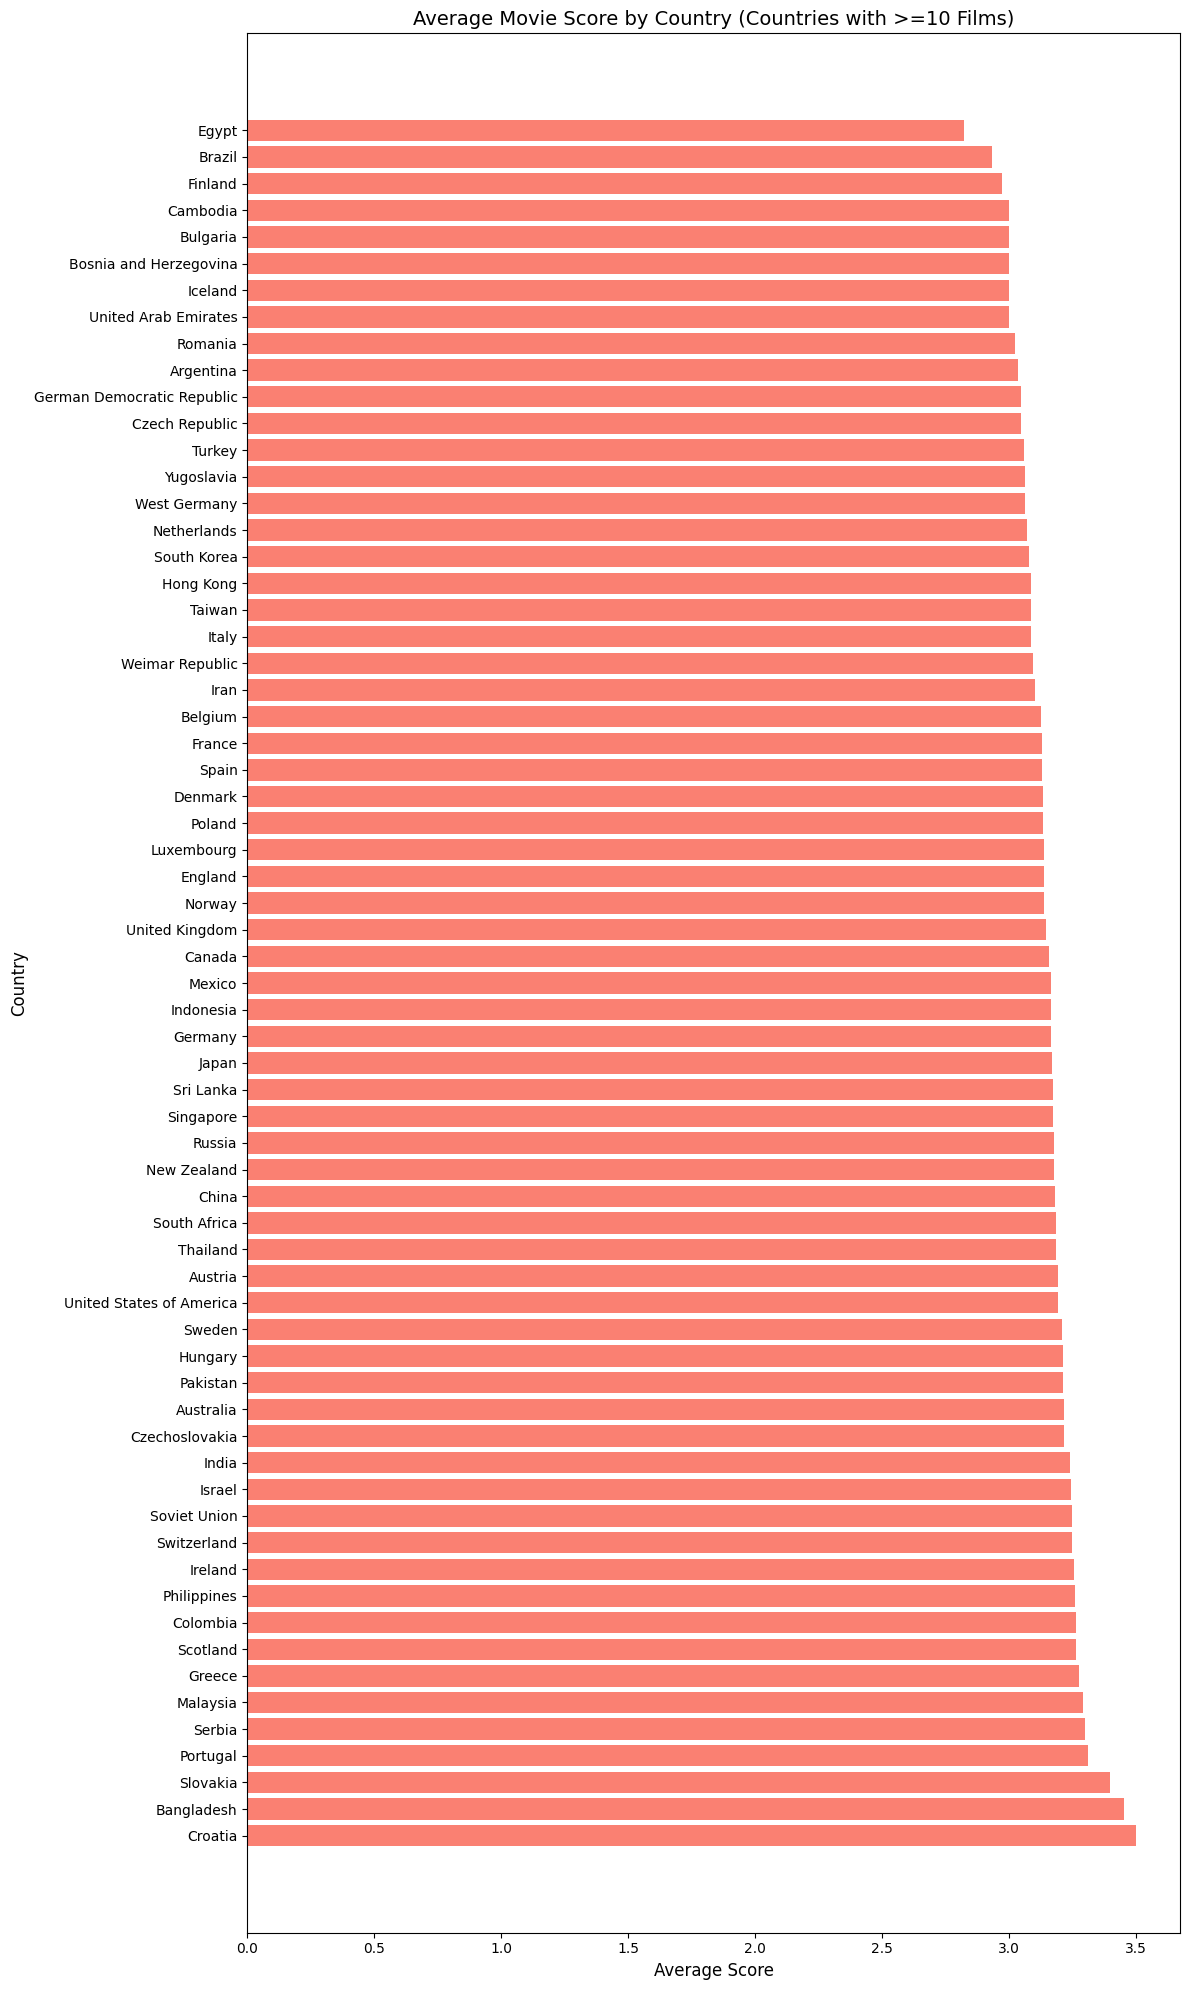

Dataset updated with cleaned 'Country' column and saved as 'movies_dataset_w_scores.tsv'


In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
movies_df = pd.read_csv('movies_dataset_w_scores.tsv', sep='\t')

# Helper function to clean up and extract country names
def extract_countries(country_data):
    if pd.isna(country_data) or '{' not in country_data:
        return None
    countries = []
    items = country_data.split(", ")
    for item in items:
        if ':' in item:
            country_name = item.split(":")[-1].strip().replace("\"", "").replace("}", "")
            countries.append(country_name)
    return ", ".join(countries) if countries else None

# Apply the function and overwrite the 'Country' column with cleaned country data
movies_df['Country'] = movies_df['Country'].apply(extract_countries)

# Drop rows with missing or invalid country data in 'Country'
movies_df = movies_df.dropna(subset=['Country']).copy()

# Explode the 'Country' column so each country has its own row
movies_df = movies_df.assign(Country=movies_df['Country'].str.split(", ")).explode('Country')

# Calculate average score and film count per country
country_stats = movies_df.groupby('Country').agg(
    Average_Score=('Score', 'mean'),
    Film_Count=('Score', 'size')
).sort_values(by='Average_Score', ascending=False)

# Filter to get countries with at least 10 films
country_stats_10_plus = country_stats[country_stats['Film_Count'] >= 10]

# Plot for all countries
plt.figure(figsize=(12, 22))
plt.barh(country_stats.index, country_stats['Average_Score'], color='skyblue')
plt.ylabel('Country', fontsize=12)
plt.xlabel('Average Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Movie Score by Country (All Countries)', fontsize=14)
plt.tight_layout()
plt.show()

# Plot for countries with at least 10 films
plt.figure(figsize=(12, 20))
plt.barh(country_stats_10_plus.index, country_stats_10_plus['Average_Score'], color='salmon')
plt.ylabel('Country', fontsize=12)
plt.xlabel('Average Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Movie Score by Country (Countries with >=10 Films)', fontsize=14)
plt.tight_layout()
plt.show()

# Save the updated dataset back to the original file
movies_df.to_csv('movies_dataset_w_scores.tsv', sep='\t', index=False)
print("Dataset updated with cleaned 'Country' column and saved as 'movies_dataset_w_scores.tsv'")


# Analysis of Average Movie Scores by Language

In this section, we aim to clean the `Languages` column in our dataset, extract individual languages, and analyze the correlation between different languages and average movie scores. Here’s a breakdown of each step in the code:

### Step 1: Language Data Cleaning
We start by defining a helper function, `extract_languages`, that processes each entry in the `Languages` column to:
1. **Ignore Empty Values**: Skip entries where the `Languages` field is empty or formatted incorrectly.
2. **Extract and Clean Language Names**: Split each entry to isolate language names, remove both "Language" and "language" suffixes, and further strip away unwanted characters such as `"` and `}`.
3. **Filter by Length**: Only retain language names that are 40 characters or fewer, removing entries that are excessively long.

After cleaning, we overwrite the `Languages` column in the dataset with the cleaned data, ensuring only valid, well-formatted languages are retained.

### Step 2: Dropping Rows with Missing Language Data
We then drop any rows in which the `Languages` field is still empty after the cleaning process. This helps ensure our dataset is consistent and that each row has a valid language entry.

### Step 3: Saving the Cleaned Dataset
The cleaned dataset is saved to a new file, `movies_dataset_with_cleaned_languages.tsv`, allowing us to use it in further analyses without re-running the cleaning process.

### Step 4: Exploding the Languages Column
Using the `.explode()` function, we split the `Languages` column so that each language listed for a movie appears in its own row. This transformation enables us to group and analyze languages independently.

### Step 5: Calculating Average Score and Film Count per Language
After exploding the languages:
1. **Calculate Average Score**: We compute the average movie score for each language.
2. **Count Films**: We count the number of films associated with each language.

### Step 6: Filtering for Languages with Significant Representation
To improve the relevance of our analysis, we filter out languages that appear in fewer than 10 films, resulting in a separate dataset that focuses on languages with a more substantial number of films.

### Step 7: Visualization
Finally, we plot two bar graphs to visualize the results:
1. **All Languages**: Displays the average score for all languages.
2. **Languages with ≥10 Films**: Focuses on languages with at least 10 films in the dataset, allowing us to identify trends in languages with more data.

By examining these graphs, we can interpret potential differences in average movie scores across various languages.


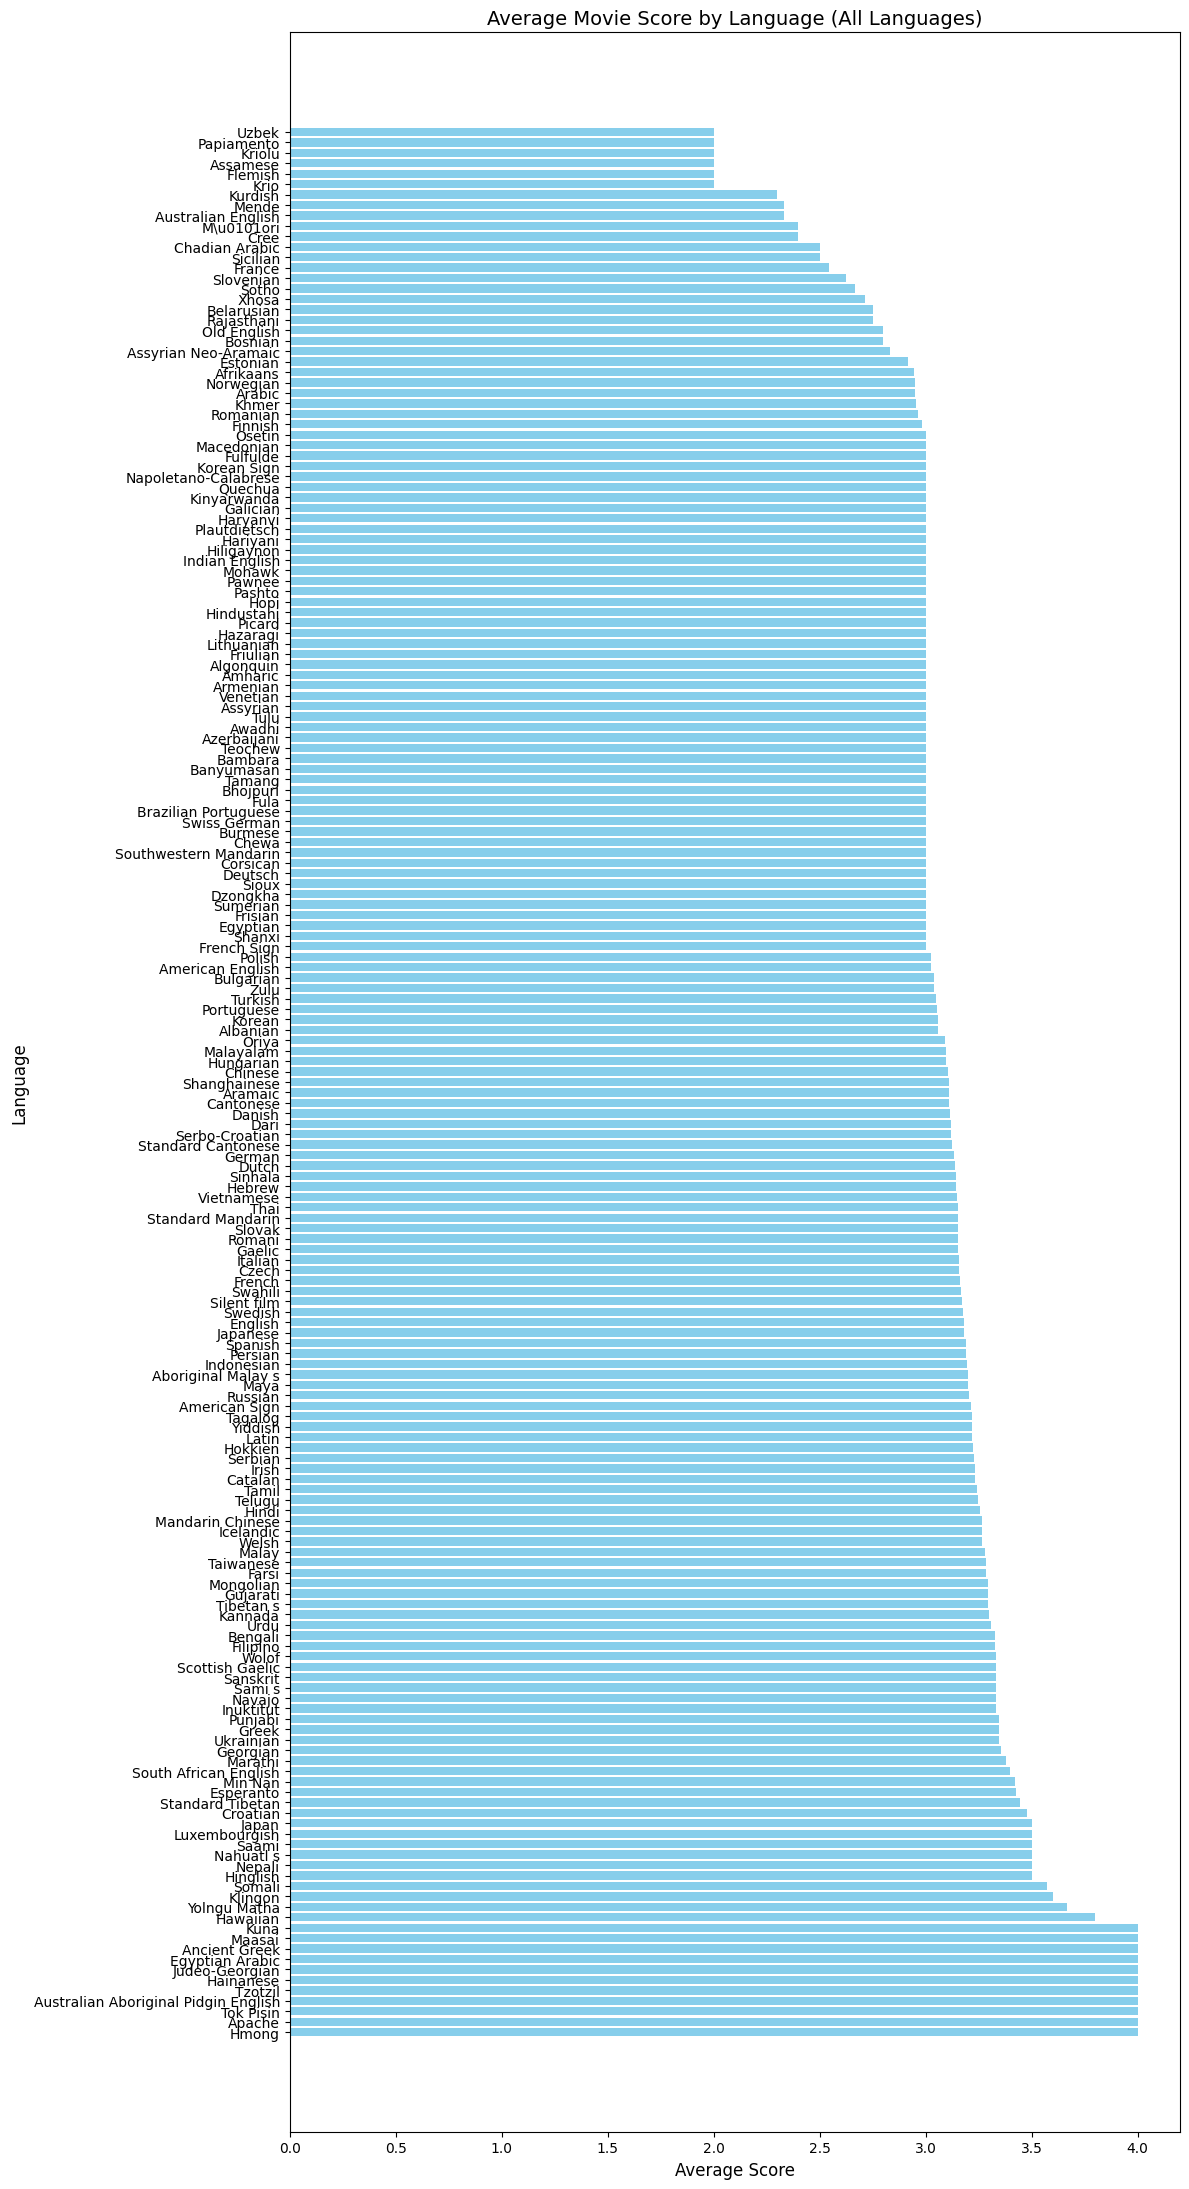

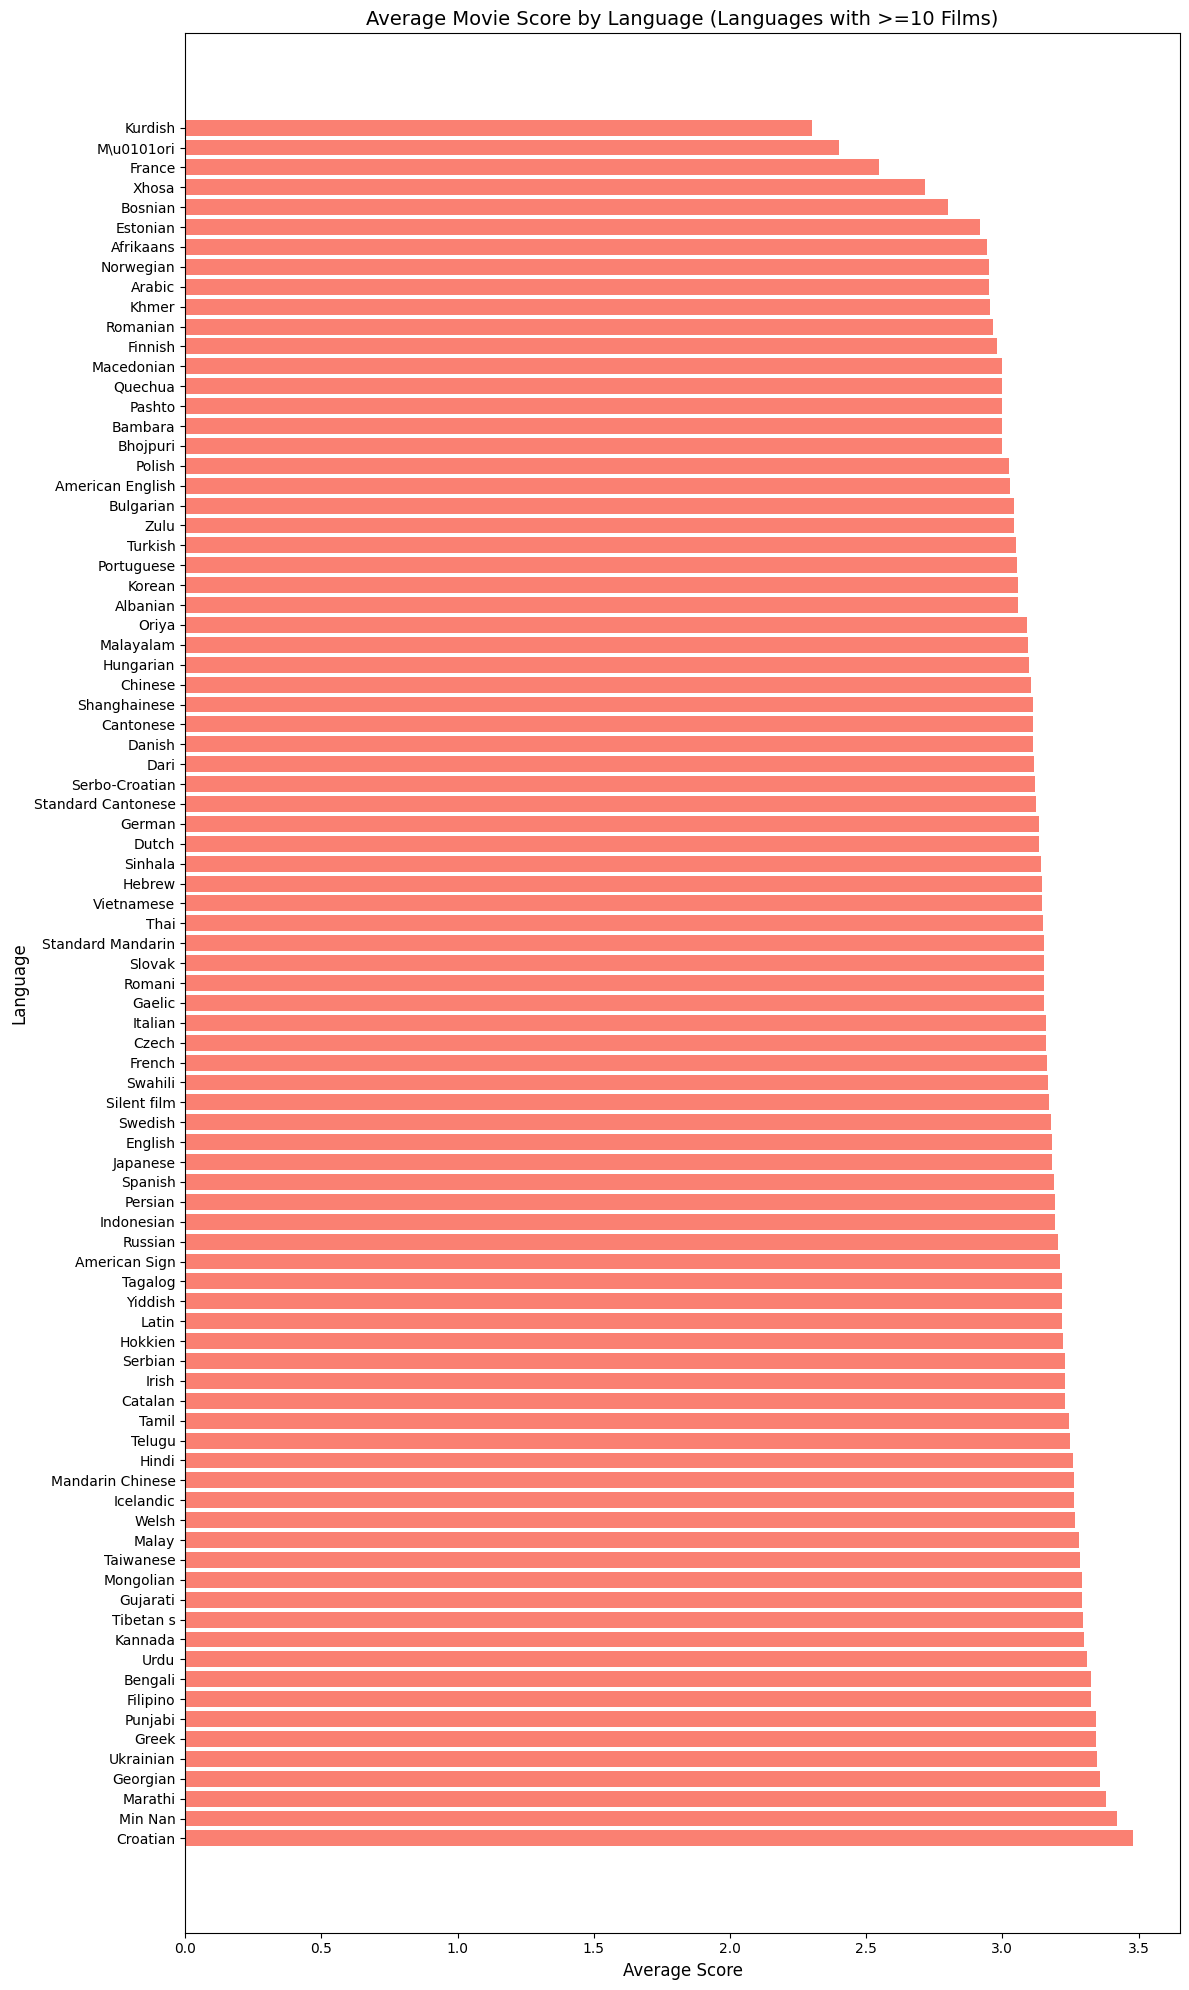

Dataset updated with cleaned 'Languages' column and saved as 'movies_dataset_w_scores.tsv'


In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
movies_df = pd.read_csv('movies_dataset_w_scores.tsv', sep='\t')

# Helper function to clean up and extract language names
def extract_languages(language_data):
    if pd.isna(language_data) or '{' not in language_data:
        return None
    languages = []
    items = language_data.split(", ")
    for item in items:
        if ':' in item:
            # Clean the language name and remove "Language"/"language"
            language_name = item.split(":")[-1].strip().replace("\"", "").replace("}", "").replace("Language", "").replace("language", "").strip()
            if len(language_name) <= 40:  # Filter out languages longer than 40 characters
                languages.append(language_name)
    return ", ".join(languages) if languages else None

# Apply the function and overwrite the 'Languages' column with cleaned language data
movies_df['Languages'] = movies_df['Languages'].apply(extract_languages)

# Drop rows with missing or invalid language data in 'Languages'
movies_df = movies_df.dropna(subset=['Languages']).copy()

# Explode the 'Languages' column so each language has its own row
exploded_lang_df = movies_df.assign(Languages=movies_df['Languages'].str.split(", ")).explode('Languages')

# Calculate average score and film count per language
language_stats = exploded_lang_df.groupby('Languages').agg(
    Average_Score=('Score', 'mean'),
    Film_Count=('Score', 'size')
).sort_values(by='Average_Score', ascending=False)

# Filter to get languages with at least 10 films
language_stats_10_plus = language_stats[language_stats['Film_Count'] >= 10]

# Plot for all languages
plt.figure(figsize=(12, 22))
plt.barh(language_stats.index, language_stats['Average_Score'], color='skyblue')
plt.ylabel('Language', fontsize=12)
plt.xlabel('Average Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Movie Score by Language (All Languages)', fontsize=14)
plt.tight_layout()
plt.show()

# Plot for languages with at least 10 films
plt.figure(figsize=(12, 20))
plt.barh(language_stats_10_plus.index, language_stats_10_plus['Average_Score'], color='salmon')
plt.ylabel('Language', fontsize=12)
plt.xlabel('Average Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Movie Score by Language (Languages with >=10 Films)', fontsize=14)
plt.tight_layout()
plt.show()

# Save the updated dataset back to the original file
movies_df.to_csv('movies_dataset_w_scores.tsv', sep='\t', index=False)
print("Dataset updated with cleaned 'Languages' column and saved as 'movies_dataset_w_scores.tsv'")


Cleaned dataset saved back to 'movies_dataset_w_scores.tsv'


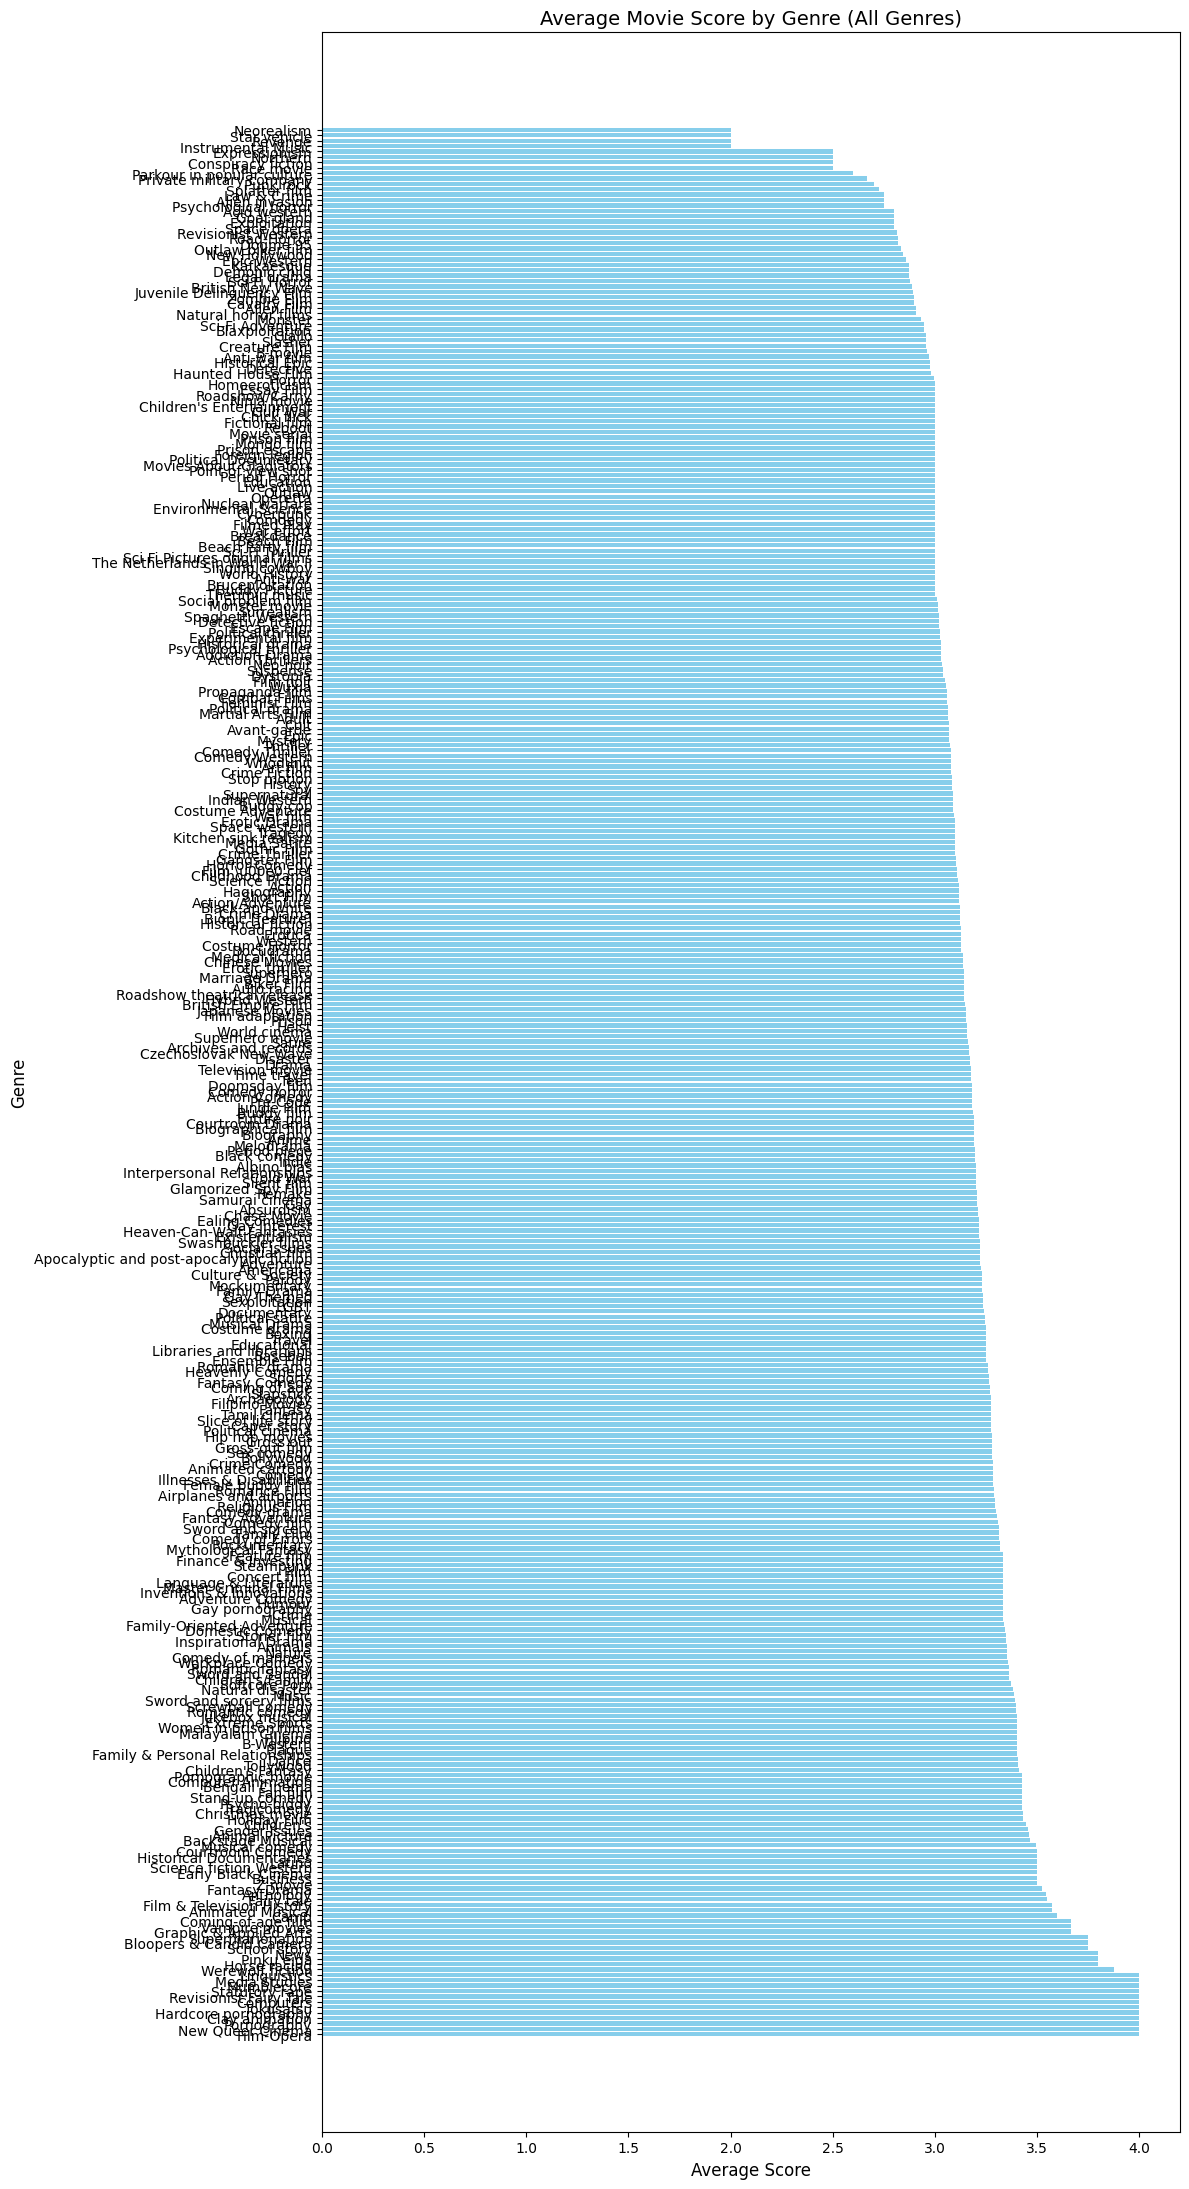

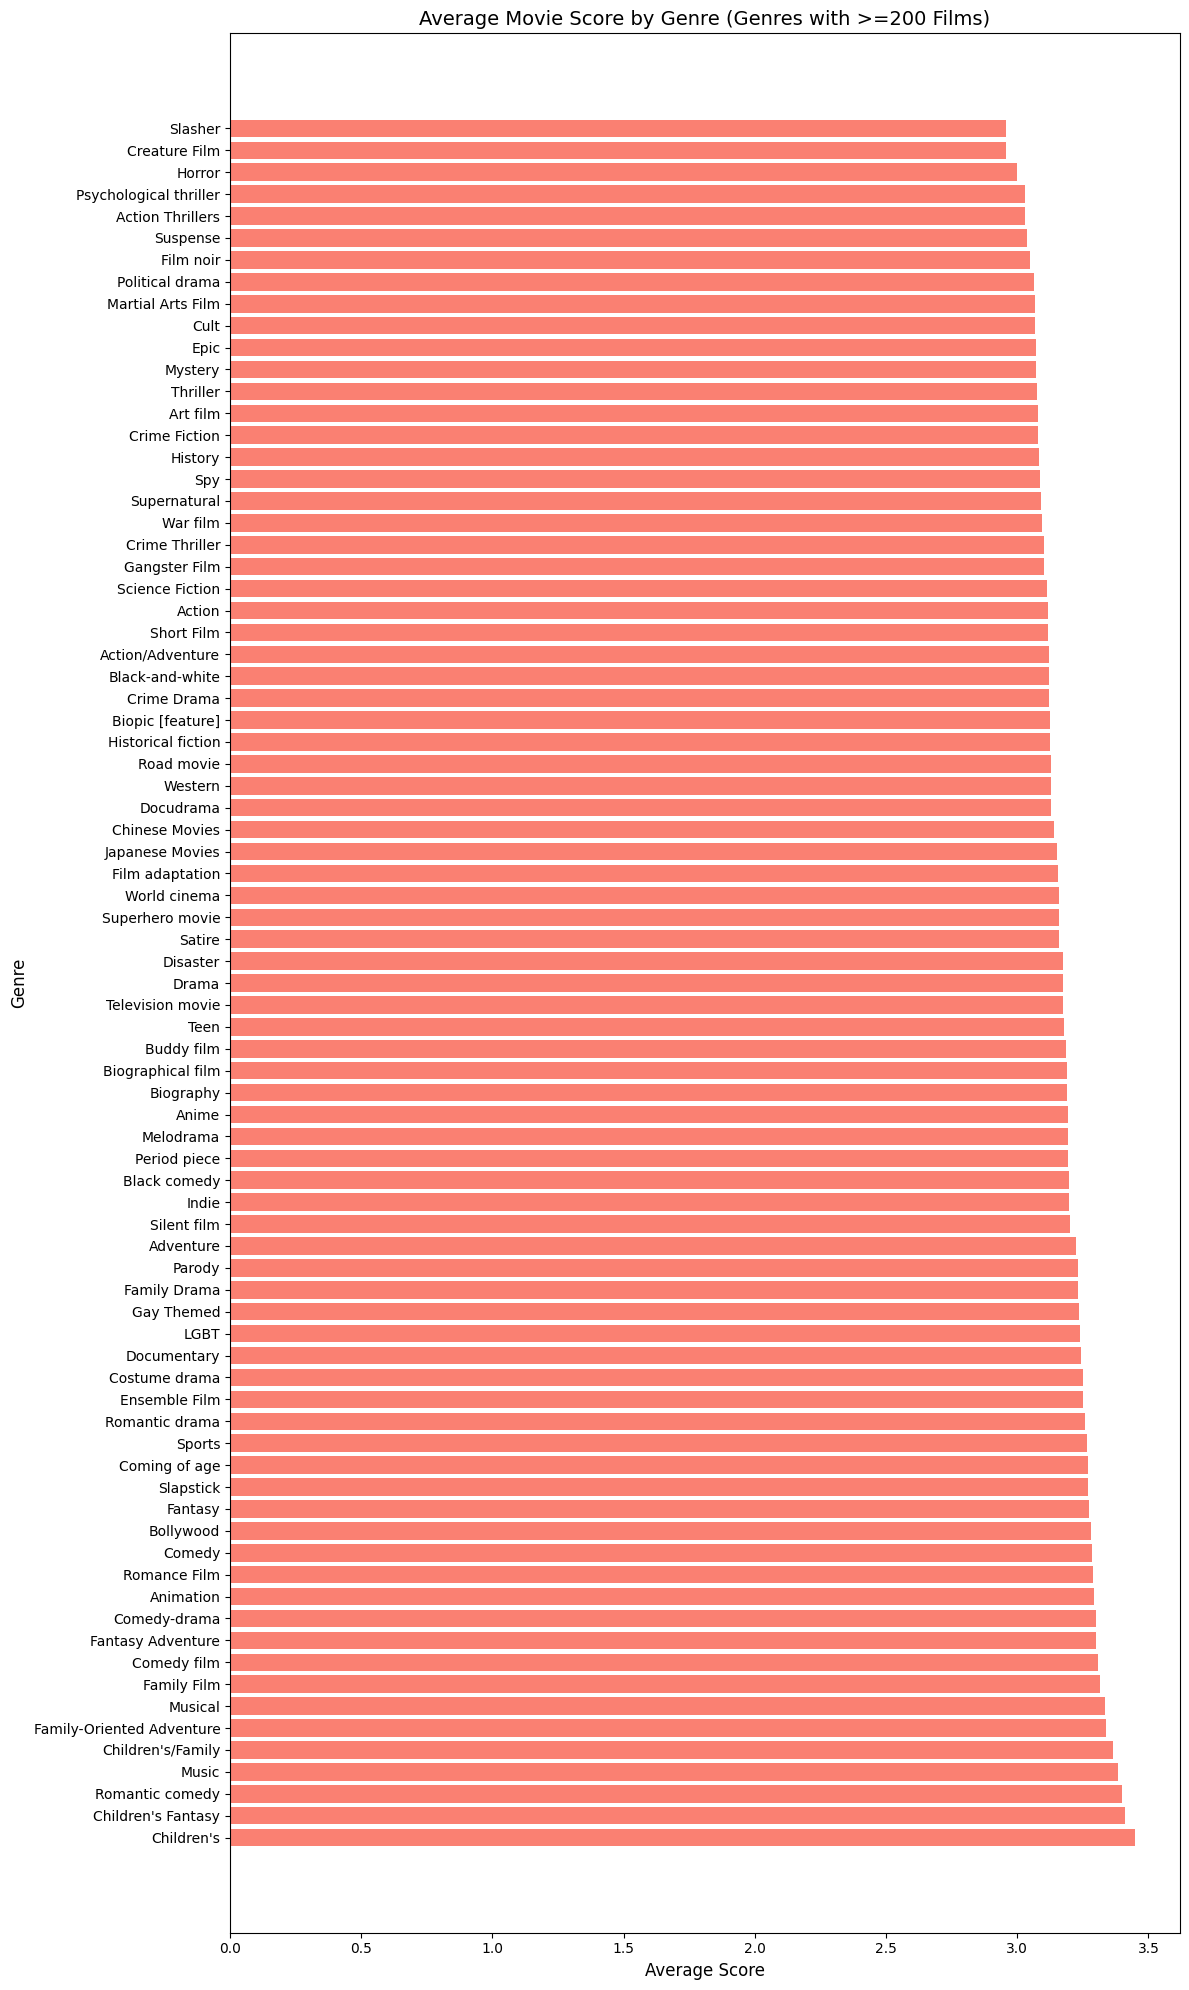

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
movies_df = pd.read_csv('movies_dataset_w_scores.tsv', sep='\t')

# Helper function to clean and extract genre names
def extract_genres(genre_data):
    if pd.isna(genre_data) or '{' not in genre_data:
        return None
    genres = []
    items = genre_data.split(", ")
    for item in items:
        if ':' in item:
            # Clean the genre name
            genre_name = item.split(":")[-1].strip().replace('"', '').replace('}', '')
            genres.append(genre_name)
    return ", ".join(genres) if genres else None

# Apply the function and overwrite the 'Genres' column with cleaned genre data
movies_df['Genres'] = movies_df['Genres'].apply(extract_genres)

# Drop rows with missing or invalid genre data in 'Genres'
movies_df = movies_df.dropna(subset=['Genres']).copy()

# Save the cleaned dataset with updated 'Genres' column back to the original file
movies_df.to_csv('movies_dataset_w_scores.tsv', sep='\t', index=False)
print("Cleaned dataset saved back to 'movies_dataset_w_scores.tsv'")

# Explode the 'Genres' column so each genre has its own row
exploded_genre_df = movies_df.assign(Genres=movies_df['Genres'].str.split(", ")).explode('Genres')

# Calculate the average score and film count per genre
genre_stats = exploded_genre_df.groupby('Genres').agg(
    Average_Score=('Score', 'mean'),
    Film_Count=('Score', 'size')
).sort_values(by='Average_Score', ascending=False)

# Filter to get genres with at least 200 films
genre_stats_200_plus = genre_stats[genre_stats['Film_Count'] >= 200]

# Plot for all genres
plt.figure(figsize=(12, 22))
plt.barh(genre_stats.index, genre_stats['Average_Score'], color='skyblue')
plt.ylabel('Genre', fontsize=12)
plt.xlabel('Average Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Movie Score by Genre (All Genres)', fontsize=14)
plt.tight_layout()
plt.show()

# Plot for genres with at least 200 films
plt.figure(figsize=(12, 20))
plt.barh(genre_stats_200_plus.index, genre_stats_200_plus['Average_Score'], color='salmon')
plt.ylabel('Genre', fontsize=12)
plt.xlabel('Average Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Movie Score by Genre (Genres with >=200 Films)', fontsize=14)
plt.tight_layout()
plt.show()


In [68]:
import pandas as pd
import re

# Load the dataset
movies_df = pd.read_csv('movies_dataset_w_scores.tsv', sep='\t')

# Define a function to extract the 4-digit year from various date formats
def extract_year(date_str):
    # Ensure the date is a string
    date_str = str(date_str)
    
    # Use regex to find a 4-digit year pattern
    match = re.search(r'\b(\d{4})\b', date_str)
    
    if match:
        return match.group(1)  # Return the matched 4-digit year as a string
    else:
        return None  # Return None if no 4-digit year is found

# Apply the function to the 'Release_Date' column to extract only the year
movies_df['Release_Date'] = movies_df['Release_Date'].apply(extract_year)

# Drop rows with no valid year (if needed)
movies_df = movies_df.dropna(subset=['Release_Date'])

# Convert 'Release_Date' to an integer type for any further analysis
movies_df['Release_Date'] = movies_df['Release_Date'].astype(int)

# Save the updated dataset with the cleaned 'Release_Date' column
movies_df.to_csv('movies_dataset_w_scores.tsv', sep='\t', index=False)

print("Dataset updated with cleaned 'Release_Date' years in 'movies_dataset_w_scores.tsv'")


Dataset updated with cleaned 'Release_Date' years in 'movies_dataset_w_scores.tsv'


### Evolution of Average Movie Score Over the Years

This code block analyzes the evolution of average movie scores over time, focusing on years with a substantial number of film releases.

1. **Data Loading**: The code reads `movies_dataset_w_scores.tsv`, which contains movie details and scores.

2. **Grouping by Year**:
   - The dataset is grouped by the `Release_Date` (now cleaned to reflect only the year).
   - For each year, two metrics are calculated:
     - **Average_Score**: The mean score of all movies released that year.
     - **Film_Count**: The total count of movies released that year.

3. **Filtering the Data**:
   - We filter out years where fewer than 100 films were released, focusing only on years with high film activity to ensure reliable average scores.

4. **Plotting**:
   - A line plot displays the evolution of the average movie score over time.
   - The x-axis represents the year, while the y-axis shows the average score.
   - Only years with at least 100 films are shown, providing a clearer view of score trends over time for popular years.

This analysis gives insight into changes in movie scores over time, highlighting how movie quality or scoring trends may have evolved.

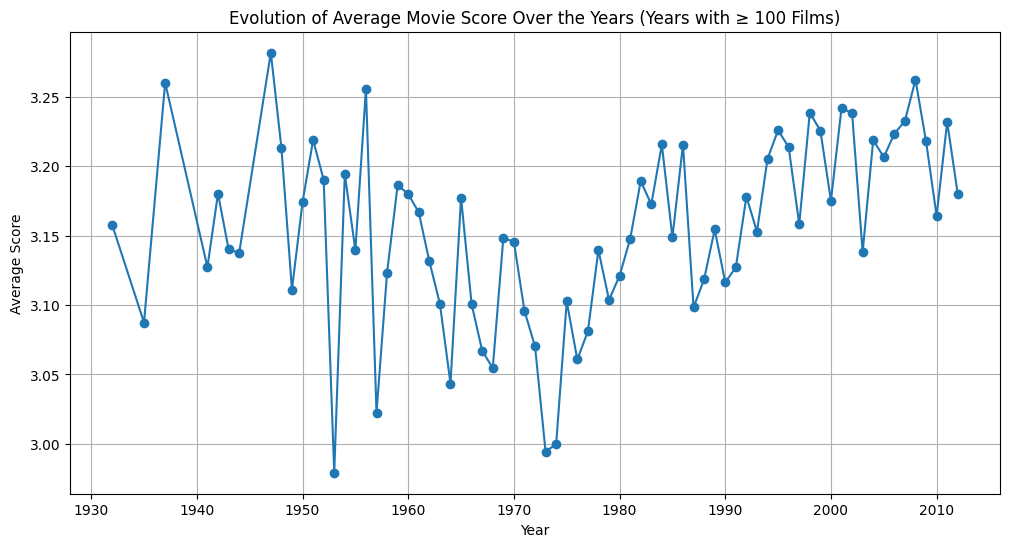

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'movies_dataset_w_scores.tsv'
movies_df = pd.read_csv(file_path, sep='\t')

score_and_count_by_year = movies_df.groupby('Release_Date').agg(
    Average_Score=('Score', 'mean'),
    Film_Count=('Score', 'size')
)

filtered_data = score_and_count_by_year[score_and_count_by_year['Film_Count'] >= 100]

plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['Average_Score'], marker='o', linestyle='-')
plt.title('Evolution of Average Movie Score Over the Years (Years with ≥ 100 Films)')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()


### Analysis of Average Movie Score by Country Over Time

This code section processes a dataset of movie scores, extracting and analyzing trends in average movie scores across different countries over the years. The following steps detail the approach and objectives of this analysis:

1. **Dataset Loading**: The dataset is loaded from a TSV file (`movies_dataset_w_scores.tsv`), which includes information about movies, release dates, countries, and scores.

2. **Country Extraction**: To handle countries listed with braces and identifiers, we define the `extract_countries` function. This function isolates the country names by removing any extra formatting characters (like `{}`, identifiers, and quotes). This helps in creating a clean list of countries associated with each movie.

3. **Data Explosion**: Since some movies are associated with multiple countries, we use the `explode` function to create individual rows for each country associated with a film. This allows us to analyze each country separately in the subsequent steps.

4. **Filtering by Yearly Film Count**: We group by country and release date, filtering only the years in which more than 5 movies were released per country. This ensures a more meaningful analysis by focusing on countries with substantial film output per year.

5. **Calculation of Average Scores**: For each country and year, the average movie score is calculated. We also filter to include only countries with at least 10 years of data, providing enough historical context for reliable trend analysis.

6. **Plotting Average Scores by Country**: Finally, for each qualifying country, a separate plot is generated to visualize the trend in average movie scores over the years. This enables us to observe changes in average movie scores within each country over time.

By performing this analysis, we can identify trends and patterns in movie scores across different countries, providing insights into the evolution of movie ratings within each region.


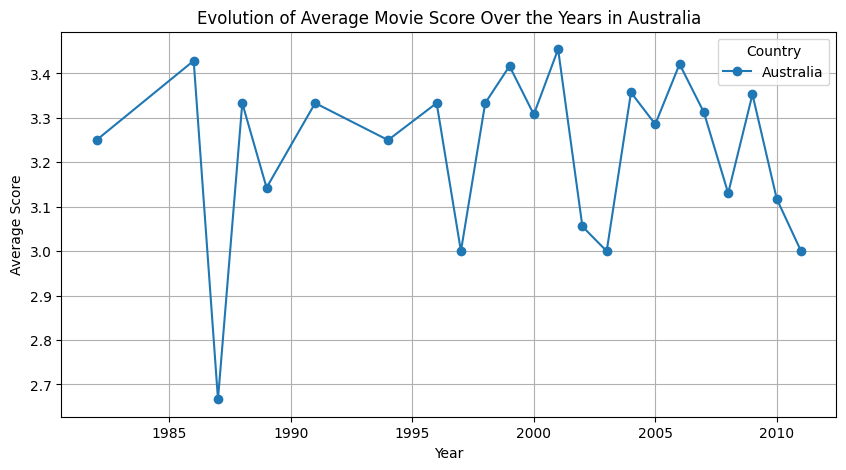

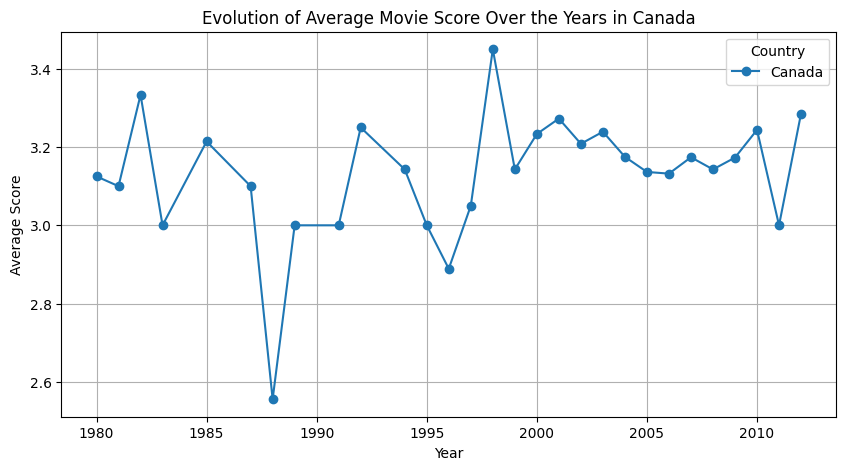

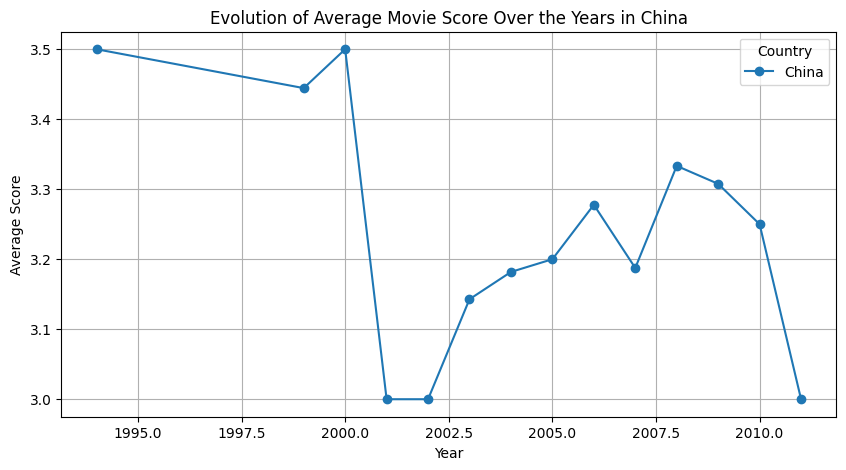

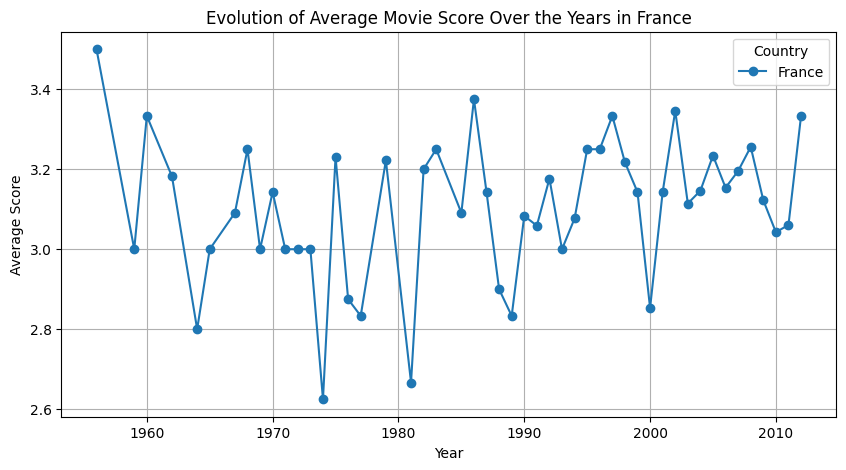

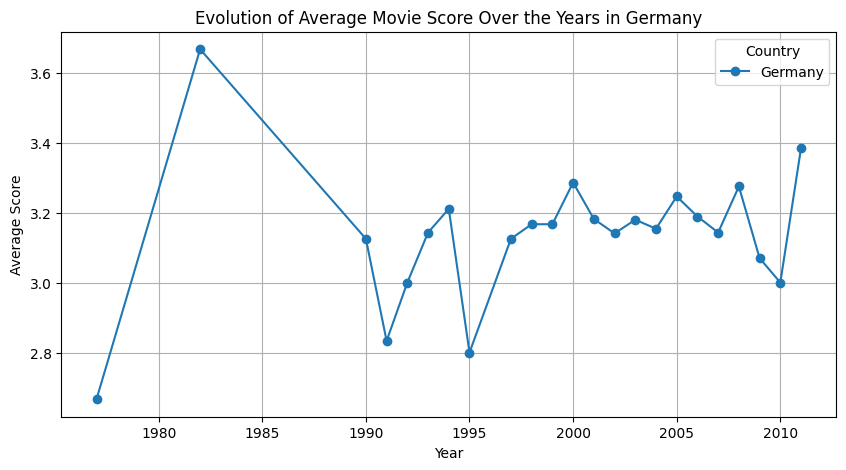

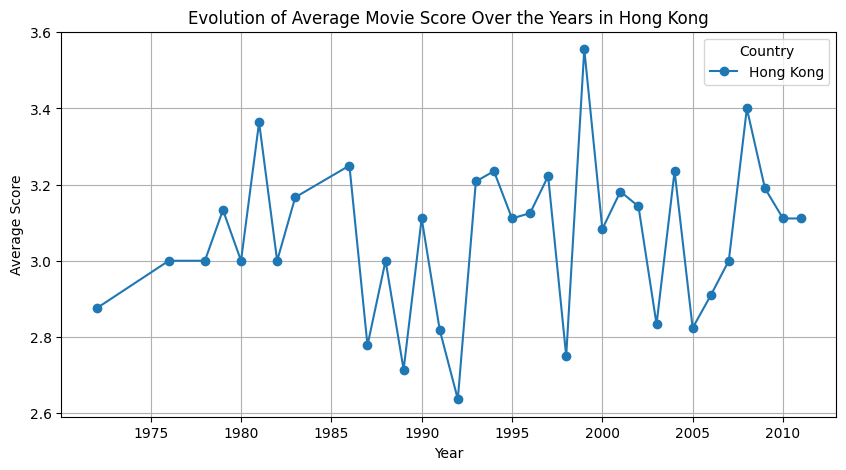

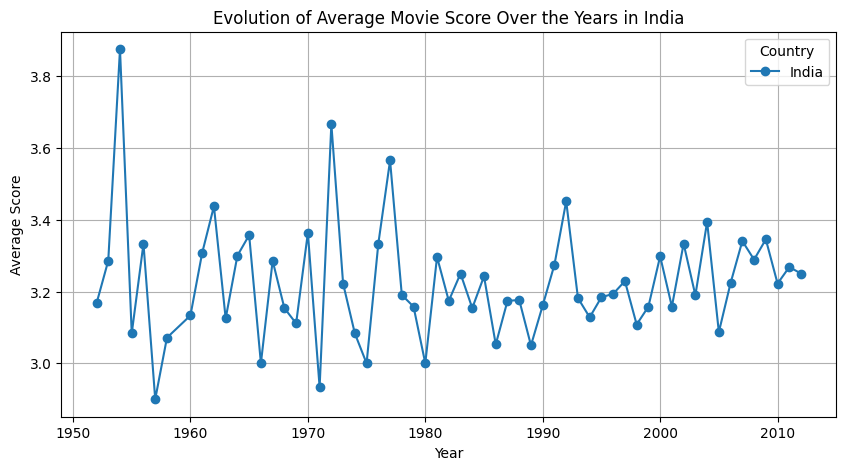

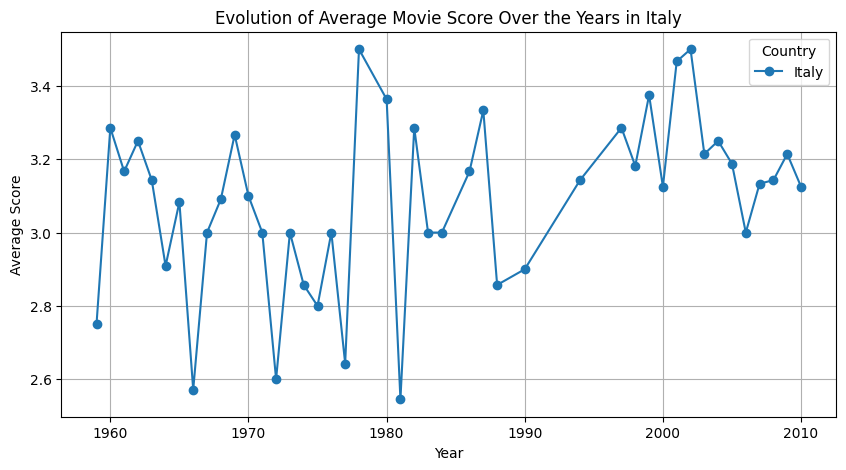

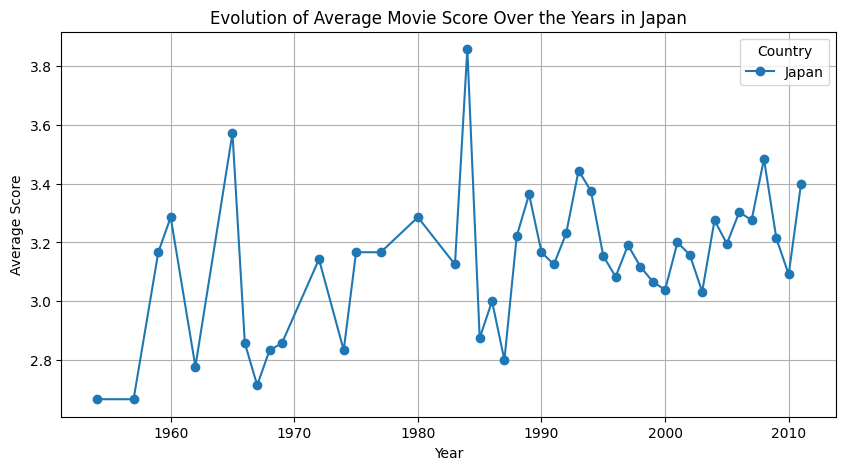

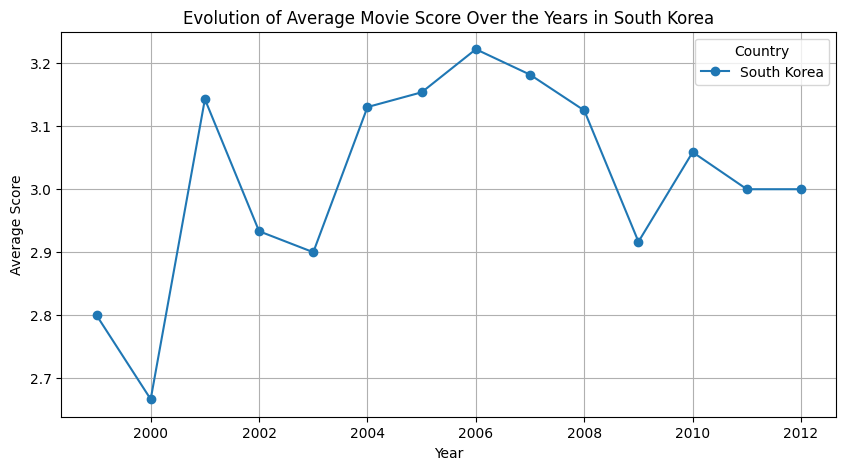

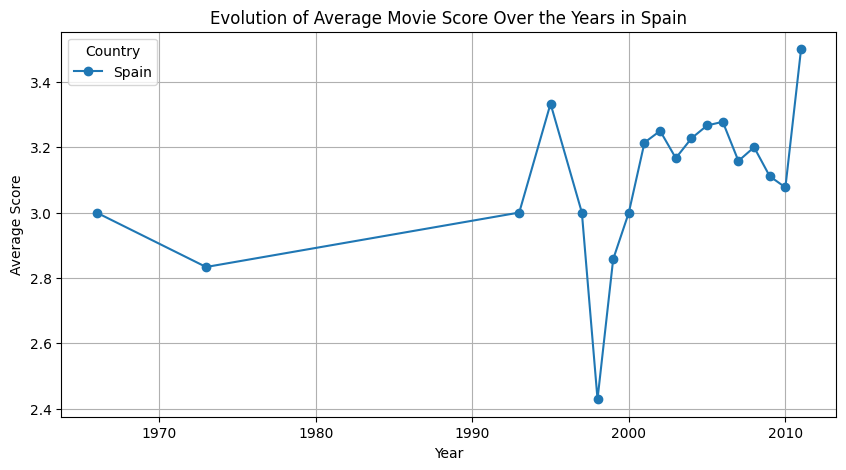

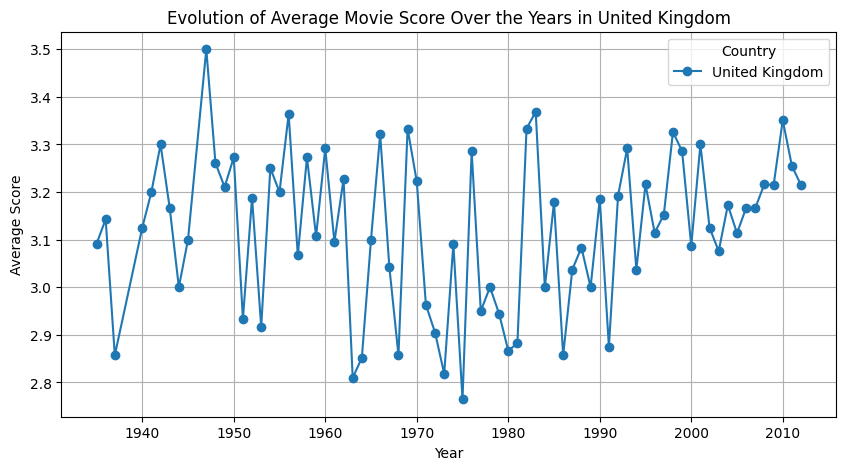

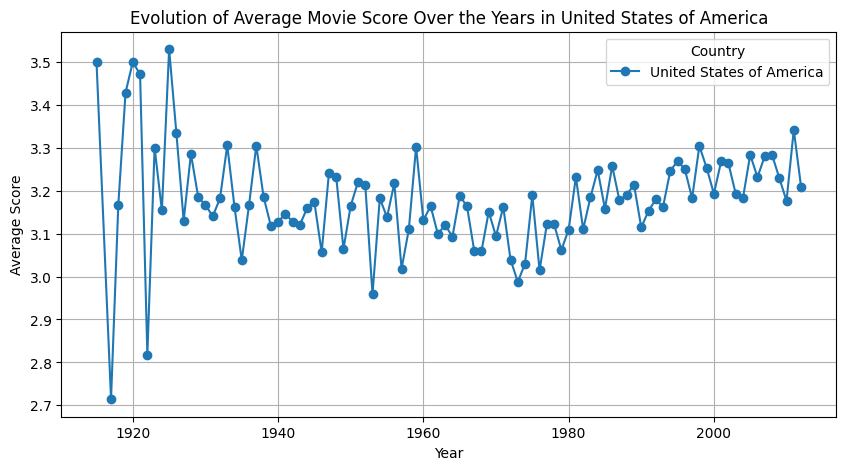

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset with years and countries
file_path = 'movies_dataset_w_scores.tsv'
movies_df = pd.read_csv(file_path, sep='\t')

# Function to extract country names by cleaning up braces and identifiers
def extract_countries(country_str):
    if pd.isna(country_str):
        return []
    countries = []
    items = country_str.split(", ")
    for item in items:
        country_name = item.split(":")[-1].strip().replace('"', '').replace('}', '').replace('{', '')
        countries.append(country_name)
    return countries

# Apply the function to separate and clean up country names
movies_df['Country'] = movies_df['Country'].apply(extract_countries)

# Explode rows so that each film is associated with one country at a time
exploded_movies_df = movies_df.explode('Country').dropna(subset=['Country'])

# Filter data for years with more than 10 films per country
films_per_year_country = exploded_movies_df.groupby(['Country', 'Release_Date']).size().reset_index(name='Film_Count')
filtered_countries = films_per_year_country[films_per_year_country['Film_Count'] > 5]

# Merge to keep only rows with enough films per year
filtered_movies_df = exploded_movies_df.merge(filtered_countries[['Country', 'Release_Date']], on=['Country', 'Release_Date'], how='inner')

# Calculate average score by country and year, keeping countries with at least 10 years of data
avg_score_by_country_year = filtered_movies_df.groupby(['Country', 'Release_Date'])['Score'].mean().reset_index()
valid_countries = avg_score_by_country_year['Country'].value_counts()
valid_countries = valid_countries[valid_countries >= 10].index
avg_score_by_country_year = avg_score_by_country_year[avg_score_by_country_year['Country'].isin(valid_countries)]

# Plot the average score trend for each country with sufficient films per year, in separate plots
for country in avg_score_by_country_year['Country'].unique():
    country_data = avg_score_by_country_year[avg_score_by_country_year['Country'] == country]
    
    plt.figure(figsize=(10, 5))
    plt.plot(country_data['Release_Date'], country_data['Score'], marker='o', linestyle='-', label=country)
    plt.title(f'Evolution of Average Movie Score Over the Years in {country}')
    plt.xlabel('Year')
    plt.ylabel('Average Score')
    plt.legend(title='Country')
    plt.grid(True)
    plt.show()
